In [1]:
%pip install openai anthropic requests datasets scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import openai
import anthropic
import requests
from datasets import load_dataset
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import re
import matplotlib.pyplot as plt
import seaborn as sns


# API keys

#change key to reliability one
O1_MINI_API_URL = 'https://api.o1mini.com/v1/generate'
O1_MINI_API_KEY = openai.api_key

anthropic_client = anthropic.Anthropic(
    api_key="",
)

openai_client = openai.OpenAI(
    api_key = "",
)


In [ ]:
# GPT queries


# GPT 3.5 Turbo query
def query_gpt3p5(prompt):
    try:
        chat_completion = openai_client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="gpt-3.5-turbo",
            temperature=0.7,
            stream=True,
        )
        response_content = ""
        for chunk in chat_completion:
            if chunk.choices[0].delta.content is not None:
                response_content += chunk.choices[0].delta.content
                print(chunk.choices[0].delta.content, end="")
        return response_content.strip()
    except Exception as e:
        print(f"GPT-3.5 Turbo Error: {e}")
        return ""


# o1-mini query
def query_o1_mini(prompt):
    try:
        chat_completion = openai_client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="gpt-4o-mini",
            temperature=0.7,
            stream=True,
        )
        response_content = ""
        for chunk in chat_completion:
            if chunk.choices[0].delta.content is not None:
                response_content += chunk.choices[0].delta.content
                print(chunk.choices[0].delta.content, end="")
        return response_content.strip()
    except Exception as e:
        print(f"GPT-4o-mini Error: {e}")
        return ""



In [ ]:
# Claude query

def query_claude(prompt):
    try:
        response_content = ""
        with anthropic_client.messages.stream(
            max_tokens=1024,
            messages=[{"role": "user", "content": prompt}],
            model="claude-3-5-sonnet-20240620",
        ) as stream:
            for text in stream.text_stream:
                response_content += text
                print(text, end="", flush=True)
        return response_content.strip()
    except Exception as e:
        print(f"Claude 3.5 Unexpected Error: {e}")
        return ""

In [ ]:
# Ensemble Evaluation

# Majority Voting

def aggregate_majority(responses):
    valid_responses = [resp for resp in responses if resp and resp.strip()]
    if not valid_responses:
        return "NOT ENOUGH INFO"
    counter = Counter(valid_responses)
    most_common, count = counter.most_common(1)[0]
    return most_common


# Weighted Voting

def aggregate_weighted(responses, models, weights):
    response_scores = {}
    for resp, model in zip(responses, models):
        if resp:
            response_scores[resp] = response_scores.get(resp, 0) + weights.get(model, 1)
    if not response_scores:
        return "Error: All models failed to generate a response."
    best_response = max(response_scores.items(), key=lambda x: x[1])[0]
    return best_response

# Secondary model response ranking

def evaluate_response(response):
    if response:
        return len(response)
    return 0

def aggregate_rerank(responses):
    scored_responses = [(resp, evaluate_response(resp)) for resp in responses if resp]
    if not scored_responses:
        return "Error: All models failed to generate a response."
    best_response = max(scored_responses, key=lambda x: x[1])[0]
    return best_response


In [ ]:
# Benchmarking, this uses the FEVER dataset for fact verificaiton

def load_fever_dataset():
    dataset = load_dataset("fever", "v1.0")
    return dataset['labelled_dev']

def compute_metrics(y_true, y_pred, labels):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )
    report = classification_report(
        y_true, y_pred, labels=labels, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'support': support,
        'classification_report': report,
        'confusion_matrix': cm
    }


def map_response_to_label(response):
    if response is None or not response.strip():
        return "NOT ENOUGH INFO"
    response_lower = response.lower()
    if "support" in response_lower:
        return "SUPPORTS"
    elif "refute" in response_lower:
        return "REFUTES"
    elif "not enough info" in response_lower or "cannot determine" in response_lower or "unknown" in response_lower:
        return "NOT ENOUGH INFO"
    else:
        return "NOT ENOUGH INFO"


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# caching function for output speed
response_cache = {}

def query_model_with_cache(model, prompt):
    cache_key = (model, prompt)
    if cache_key in response_cache:
        return response_cache[cache_key]
    else:
        if model == 'gpt-3.5-turbo':
            resp = query_gpt3p5(prompt)
        elif model == 'gpt-4o-mini':
            resp = query_o1_mini(prompt)
        elif model == 'claude-3.5':
            resp = query_claude(prompt)
        else:
            resp = None
            print(f"Unsupported model: {model}")
        response_cache[cache_key] = resp
        return resp

In [ ]:
# Ensemble Execution

def ensemble(models, prompt, aggregation_method='majority', weights=None):
    responses = []
    for model in models:
        if model == 'gpt-3.5-turbo':
            resp = query_gpt3p5(prompt)
        elif model == 'gpt-4o-mini':
            resp = query_o1_mini(prompt)
        elif model == 'claude-3.5':
            resp = query_claude(prompt)
        else:
            resp = None
            print(f"Unsupported model: {model}")
        responses.append(resp)

    if aggregation_method == 'majority':
        return aggregate_majority(responses)
    elif aggregation_method == 'weighted' and weights:
        return aggregate_weighted(responses, models, weights)
    elif aggregation_method == 'rerank':
        return aggregate_rerank(responses)
    else:
        return "Error: Unsupported aggregation method or missing weights."

# eval loop
def evaluate_ensemble_on_fever(num_samples=1000):
    dataset = load_fever_dataset()
    dataset = dataset.select(range(num_samples))
    y_true = []

    models = ['gpt-3.5-turbo', 'gpt-4o-mini', 'claude-3.5']
    model_weights = {
        'gpt-3.5-turbo': 1.5,
        'gpt-4o-mini': 1.2,
        'claude-3.5': 1.0
    }

    model_predictions = {model: [] for model in models}
    ensemble_predictions = {
        'majority': [],
        'weighted': [],
        'rerank': []
    }

    for sample in dataset:
        claim = sample['claim']
        label = sample['label']
        y_true.append(label)

        prompt = f"Fact-check the following claim and respond with SUPPORTS, REFUTES, or NOT ENOUGH INFO: \"{claim}\""

        responses = []
        responses_dict = {}
        for model in models:
            resp = query_model_with_cache(model, prompt)
            responses.append(resp)
            responses_dict[model] = resp


        for model in models:
            predicted_label = map_response_to_label(responses_dict[model])
            model_predictions[model].append(predicted_label)

        # Ensemble predictions
        ensemble_response_majority = aggregate_majority(responses)
        predicted_label_majority = map_response_to_label(ensemble_response_majority)
        ensemble_predictions['majority'].append(predicted_label_majority)

        ensemble_response_weighted = aggregate_weighted(responses, models, model_weights)
        predicted_label_weighted = map_response_to_label(ensemble_response_weighted)
        ensemble_predictions['weighted'].append(predicted_label_weighted)

        ensemble_response_rerank = aggregate_rerank(responses)
        predicted_label_rerank = map_response_to_label(ensemble_response_rerank)
        ensemble_predictions['rerank'].append(predicted_label_rerank)

        print(f"Claim: {claim}")
        print(f"True Label: {label}")
        for model in models:
            print(f"Prediction by {model}: {model_predictions[model][-1]}")
        print(f"Majority Vote Prediction: {predicted_label_majority}")
        print(f"Weighted Vote Prediction: {predicted_label_weighted}")
        print(f"Rerank Prediction: {predicted_label_rerank}")
        print("-" * 50)

    labels = ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']

    print("Individual Model Evaluation Metrics:")
    for model in models:
        metrics = compute_metrics(y_true, model_predictions[model], labels)
        print(f"{model} Accuracy: {metrics['accuracy']:.2f}")
        print("Classification Report:\n", metrics['classification_report'])
        plot_confusion_matrix(metrics['confusion_matrix'], labels, f'Confusion Matrix - {model}')

    print("Ensemble Methods Evaluation Metrics:")
    for method in ensemble_predictions:
        metrics = compute_metrics(y_true, ensemble_predictions[method], labels)
        print(f"{method.capitalize()} Voting Accuracy: {metrics['accuracy']:.2f}")
        print("Classification Report:\n", metrics['classification_report'])
        plot_confusion_matrix(metrics['confusion_matrix'], labels, f'Confusion Matrix - {method.capitalize()} Voting')

Streaming output truncated to the last 5000 lines.
The band has gone through various lineup changes over the decades, but Carlos Santana has remained the constant member and leader. Without more specific context or information about what the claim might be referring to, it's not possible to accurately fact-check this statement.

Given the inaccuracy in the formation year and the lack of evidence for a disbanding in 1965, the most appropriate response is "NOT ENOUGH INFO."Claim: Carlos Santana disbanded Santana in 1965.
True Label: REFUTES
Prediction by gpt-3.5-turbo: REFUTES
Prediction by gpt-4o-mini: REFUTES
Prediction by claude-3.5: SUPPORTS
Majority Vote Prediction: REFUTES
Weighted Vote Prediction: REFUTES
Rerank Prediction: SUPPORTS
--------------------------------------------------
Claim: Carlos Santana disbanded Santana in 1965.
True Label: REFUTES
Prediction by gpt-3.5-turbo: REFUTES
Prediction by gpt-4o-mini: REFUTES
Prediction by claude-3.5: SUPPORTS
Majority Vote Prediction:

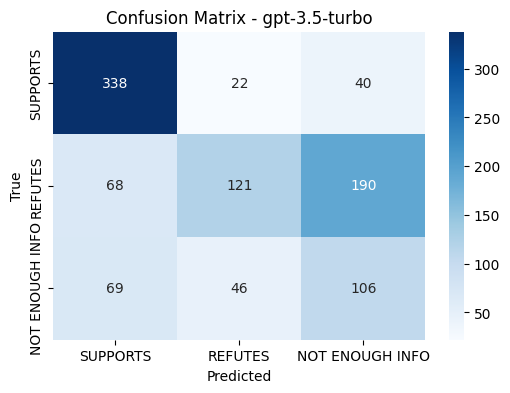

gpt-4o-mini Accuracy: 0.61
Classification Report:
                  precision    recall  f1-score   support

       SUPPORTS       0.70      0.64      0.67       400
        REFUTES       0.61      0.87      0.72       379
NOT ENOUGH INFO       0.24      0.11      0.15       221

       accuracy                           0.61      1000
      macro avg       0.52      0.54      0.51      1000
   weighted avg       0.57      0.61      0.57      1000



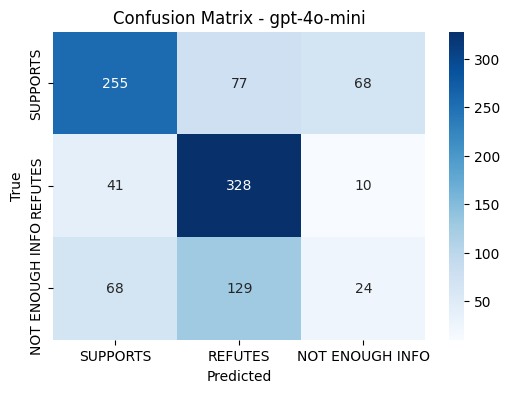

claude-3.5 Accuracy: 0.62
Classification Report:
                  precision    recall  f1-score   support

       SUPPORTS       0.60      0.92      0.72       400
        REFUTES       0.68      0.64      0.66       379
NOT ENOUGH INFO       0.25      0.04      0.06       221

       accuracy                           0.62      1000
      macro avg       0.51      0.53      0.48      1000
   weighted avg       0.55      0.62      0.55      1000



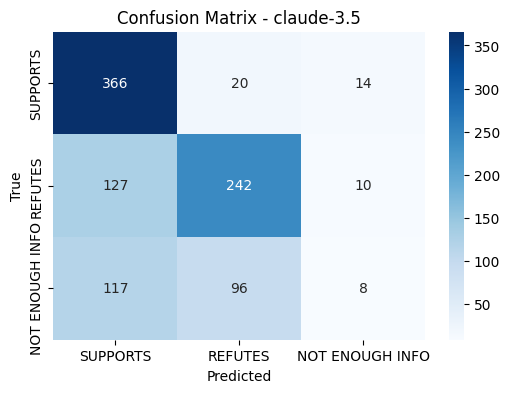

Ensemble Methods Evaluation Metrics:
Majority Voting Accuracy: 0.56
Classification Report:
                  precision    recall  f1-score   support

       SUPPORTS       0.71      0.84      0.77       400
        REFUTES       0.64      0.32      0.43       379
NOT ENOUGH INFO       0.32      0.48      0.38       221

       accuracy                           0.56      1000
      macro avg       0.56      0.55      0.53      1000
   weighted avg       0.60      0.56      0.55      1000



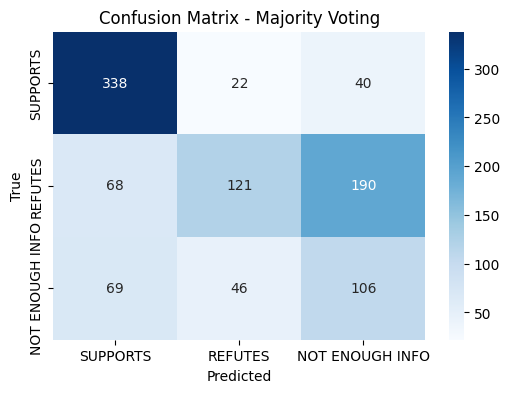

Weighted Voting Accuracy: 0.56
Classification Report:
                  precision    recall  f1-score   support

       SUPPORTS       0.71      0.84      0.77       400
        REFUTES       0.64      0.32      0.43       379
NOT ENOUGH INFO       0.32      0.48      0.38       221

       accuracy                           0.56      1000
      macro avg       0.56      0.55      0.53      1000
   weighted avg       0.60      0.56      0.55      1000



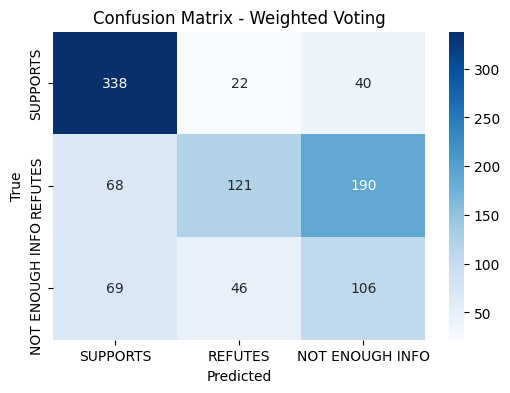

Rerank Voting Accuracy: 0.62
Classification Report:
                  precision    recall  f1-score   support

       SUPPORTS       0.60      0.92      0.72       400
        REFUTES       0.68      0.64      0.66       379
NOT ENOUGH INFO       0.25      0.04      0.06       221

       accuracy                           0.62      1000
      macro avg       0.51      0.53      0.48      1000
   weighted avg       0.55      0.62      0.55      1000



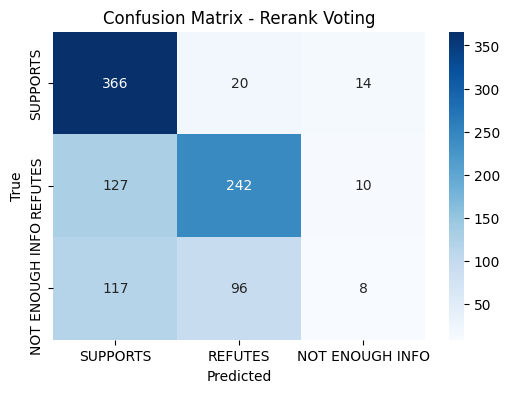

In [ ]:
evaluate_ensemble_on_fever()